# Bonus Certificates with Cap

**Author:** Thoran Tschöpe, [names]  
**Course:** Financial Mathematics 2  
**Professor:** Prof. Dr. Rudi Zagst  
**Institution:** Technical University of Munich, Department of Mathematics  
**Date:** June 2025

This notebook presents a comprehensive analysis of Bonus Certificates with Cap, a structured financial product that combines features of both protection and participation.

## Table of Contents

1. [Data Analysis and Exploration](#1-data-analysis-and-exploration)
2. [Black-Scholes Model Calibration](#2-black-scholes-model-calibration)
3. [Understanding Bonus Certificates with Cap](#3-understanding-bonus-certificates-with-cap)
4. [Replication Strategy](#4-replication-strategy)
5. [Analytical Pricing](#5-analytical-pricing)
6. [Monte Carlo Simulation](#6-monte-carlo-simulation)
7. [Risk Analysis](#7-risk-analysis)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### 1. Data Analysis and Exploration

In [2]:
def load_and_prepare_data(filepath):
    """
    Load stock data and calculate log returns.
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file containing stock data
        
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with Date, Close price, and log returns
    """
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Calculate log returns
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Remove NaN values
    df = df.dropna()
    
    return df

def plot_stock_evolution(df):
    """
    Create plots for stock price evolution and log returns.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Stock Price Evolution
    ax1.plot(df.index, df['Close'], linewidth=2, color='darkblue')
    ax1.set_title('Deutsche Telekom Stock Price Evolution', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Price (EUR)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # moving averages
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    ax1.plot(df.index, df['MA50'], linewidth=1, color='orange', alpha=0.7, label='50-day MA')
    ax1.plot(df.index, df['MA200'], linewidth=1, color='red', alpha=0.7, label='200-day MA')
    ax1.legend(loc='best')
    
    # Plot 2: Log Returns
    ax2.plot(df.index, df['Log_Returns'], linewidth=0.5, color='darkgreen', alpha=0.8)
    ax2.set_title('Log Returns of Deutsche Telekom Stock', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Log Returns', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # horizontal line at zero
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def calculate_statistics(df):
    """
    Calculate and display comprehensive statistics for log returns.
    """
    log_returns = df['Log_Returns']
    
    statistics = {
        'Mean': log_returns.mean(),
        'Standard Deviation': log_returns.std(),
        'Minimum': log_returns.min(),
        'Maximum': log_returns.max(),
        'Skewness': stats.skew(log_returns),
        'Kurtosis': stats.kurtosis(log_returns),
        'Q1 (25th percentile)': log_returns.quantile(0.25),
        'Q2 (Median)': log_returns.quantile(0.50),
        'Q3 (75th percentile)': log_returns.quantile(0.75),
        'Annualized Mean': log_returns.mean() * 252,
        'Annualized Volatility': log_returns.std() * np.sqrt(252),
        'Sharpe Ratio (rf=2%)': (log_returns.mean() * 252 - 0.02) / (log_returns.std() * np.sqrt(252))
    }
    
    # Create a nice formatted table
    stats_df = pd.DataFrame(list(statistics.items()), 
                           columns=['Statistic', 'Value'])
    
    print("=" * 50)
    print("LOG RETURNS STATISTICS")
    print("=" * 50)
    print(stats_df.to_string(index=False))
    
    # Distribution plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(log_returns, bins=50, density=True, alpha=0.7, 
                              color='skyblue', edgecolor='black')
    
    # Fit normal distribution
    mu, sigma = log_returns.mean(), log_returns.std()
    x = np.linspace(log_returns.min(), log_returns.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
            label=f'Normal({mu:.4f}, {sigma:.4f})')
    
    ax.set_title('Distribution of Log Returns', fontsize=16, fontweight='bold')
    ax.set_xlabel('Log Returns', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return statistics


Data loaded: 2540 observations
Date range: 2014-06-18 00:00:00 to 2024-06-14 00:00:00


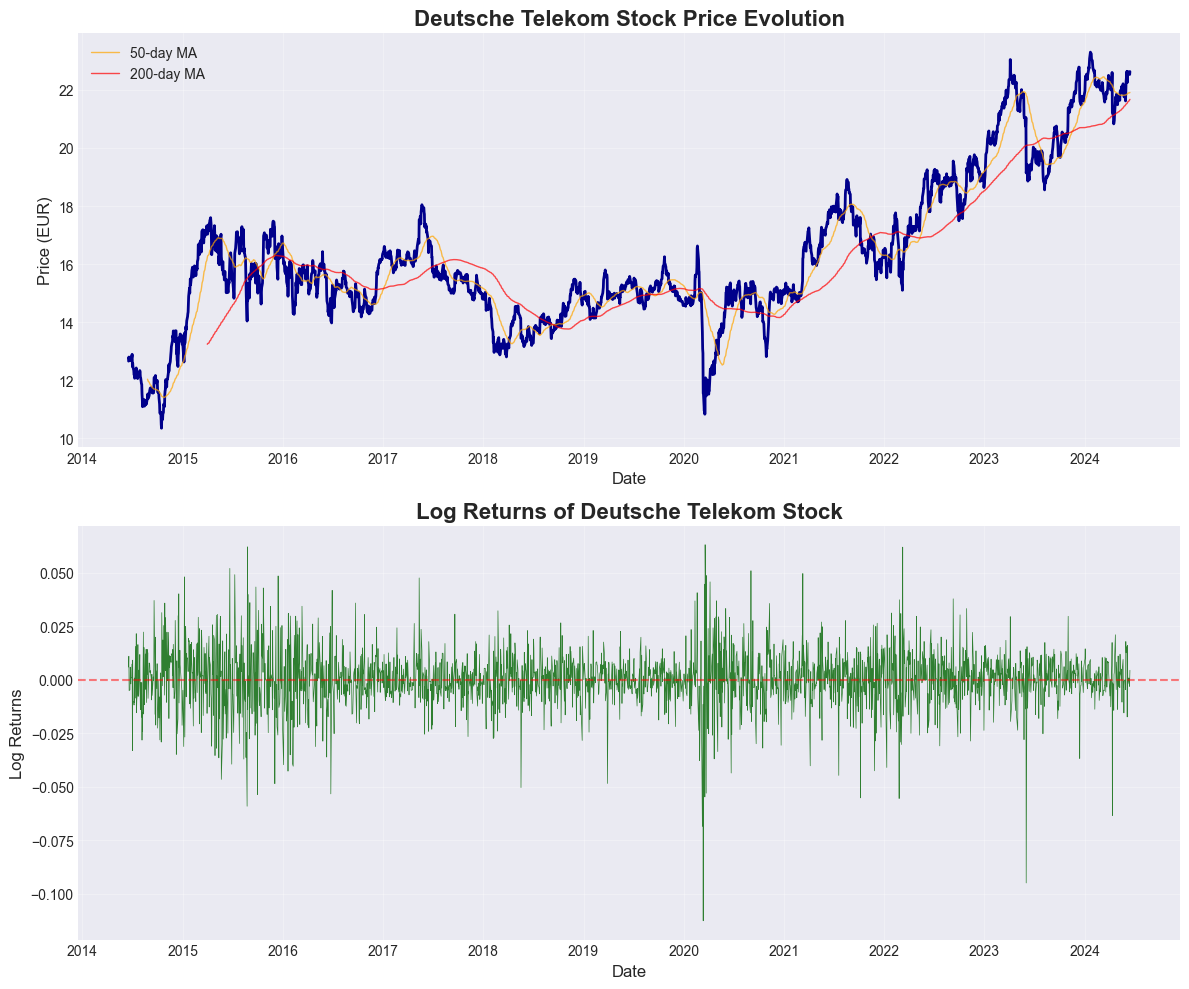

LOG RETURNS STATISTICS
            Statistic     Value
                 Mean  0.000231
   Standard Deviation  0.013379
              Minimum -0.112673
              Maximum  0.063141
             Skewness -0.464677
             Kurtosis  5.606269
 Q1 (25th percentile) -0.005909
          Q2 (Median)  0.000000
 Q3 (75th percentile)  0.007092
      Annualized Mean  0.058215
Annualized Volatility  0.212393
 Sharpe Ratio (rf=2%)  0.179926


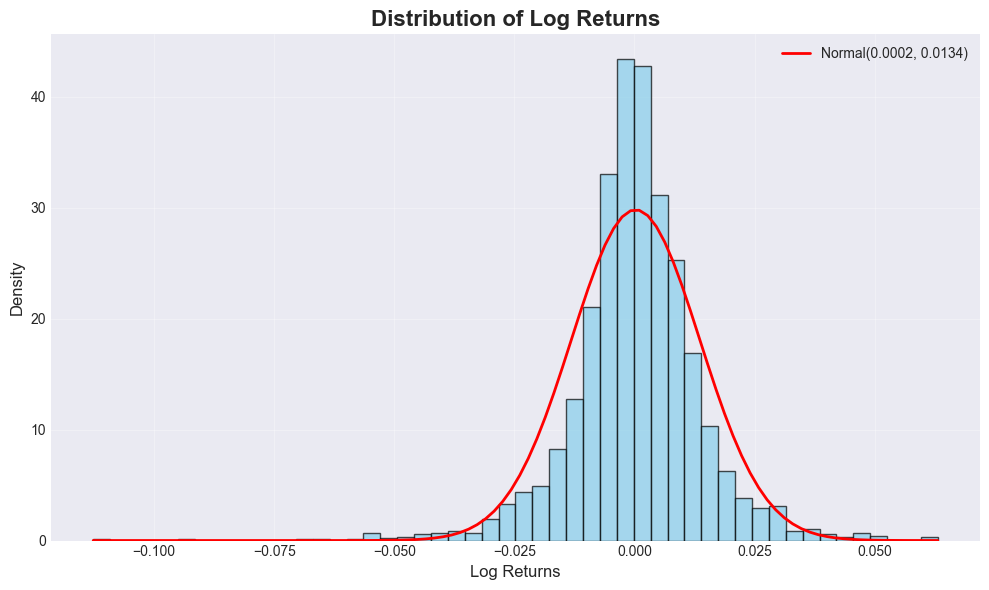

In [3]:
df = load_and_prepare_data('Telekom.csv')
print(f"Data loaded: {len(df)} observations")
print(f"Date range: {df.index[0]} to {df.index[-1]}")

plot_stock_evolution(df)

stats_dict = calculate_statistics(df)

### 2. Black-Scholes Model Calibration

In [4]:
def fit_black_scholes(log_returns, dt=1/252):
    """
    Fit Black-Scholes model using direct calculation of parameters.
    
    Parameters:
    -----------
    log_returns : array-like
        Array of log returns
    dt : float
        Time increment (default: 1/252 for daily data)
        
    Returns:
    --------
    dict : Dictionary containing estimated parameters
    """
    sigma_hat = np.std(log_returns, ddof=1) / np.sqrt(dt)
    mu_hat = np.mean(log_returns) / dt + sigma_hat**2 / 2
    
    results = {
        'drift': mu_hat,
        'volatility': sigma_hat,
    }
    
    return results

In [5]:
print("Days in each year:")
df.index.year.value_counts().sort_index()

Days in each year:


Date
2014    136
2015    254
2016    255
2017    255
2018    252
2019    251
2020    254
2021    255
2022    257
2023    255
2024    116
Name: count, dtype: int64

In [6]:
bs_params = fit_black_scholes(df['Log_Returns'].values)

print(f"Estimated drift (µ): {bs_params['drift']:.4f}")
print(f"Estimated volatility (σ): {bs_params['volatility']:.4f}")

Estimated drift (µ): 0.0808
Estimated volatility (σ): 0.2124


### 3. Understanding Bonus Certificates with Cap

### Bonus Certificates with Cap – Comprehensive Overview

#### 1. Definition and Structure

A Bonus Certificate with Cap is a structured product that offers:

- Protection against moderate downside movements (down to the barrier level)
- A guaranteed bonus payment if the barrier is never breached
- Limited upside potential due to the cap

---

#### 2. Key Components

- **Initial Level** ($P_0$): Starting price of the underlying  
- **Barrier Level** ($H$): Protection threshold
- **Bonus Level** ($B$): Guaranteed payment if barrier is not breached  
- **Cap Level** ($C$): Maximum payout level  
- **Maturity** ($T$): Certificate expiration date  

---

#### 3. Payoff Profile

At maturity, the payoff depends on two conditions:

##### a) If the barrier is never touched during the life of the certificate:

$$
\text{Payoff} = \min\left( \max(P_T, B), C \right)
$$

##### b) If the barrier is touched at least once:

$$
\text{Payoff} = \min(P_T, C)
$$

---

#### 4. Investor Motivation

- **Protection:** Limited downside risk if the underlying doesn't fall too much  
- **Bonus:** Attractive return even in sideways markets  
- **Simplicity:** Clear and transparent payoff structure  
- **Yield Enhancement:** Better returns than bonds in moderate scenarios  

---

#### 5. Risks to Consider

- **Barrier Breach:** Loss of bonus and protection if barrier is touched  
- **Volatility:** High volatility in the underlying increases risk of barrier being touched, which voids bonus protection
- **Capped Upside:** Cannot benefit from strong rallies above the cap  
- **Credit Risk:** Issuer default risk (certificate is an unsecured bond)  
- **Path Dependency:** Payoff depends on the entire price path, not just the final value  
- **Opportunity Cost:** May underperform direct investment in bull markets  
- **Dividend Waiver:** No dividends from the underlying are passed to investors


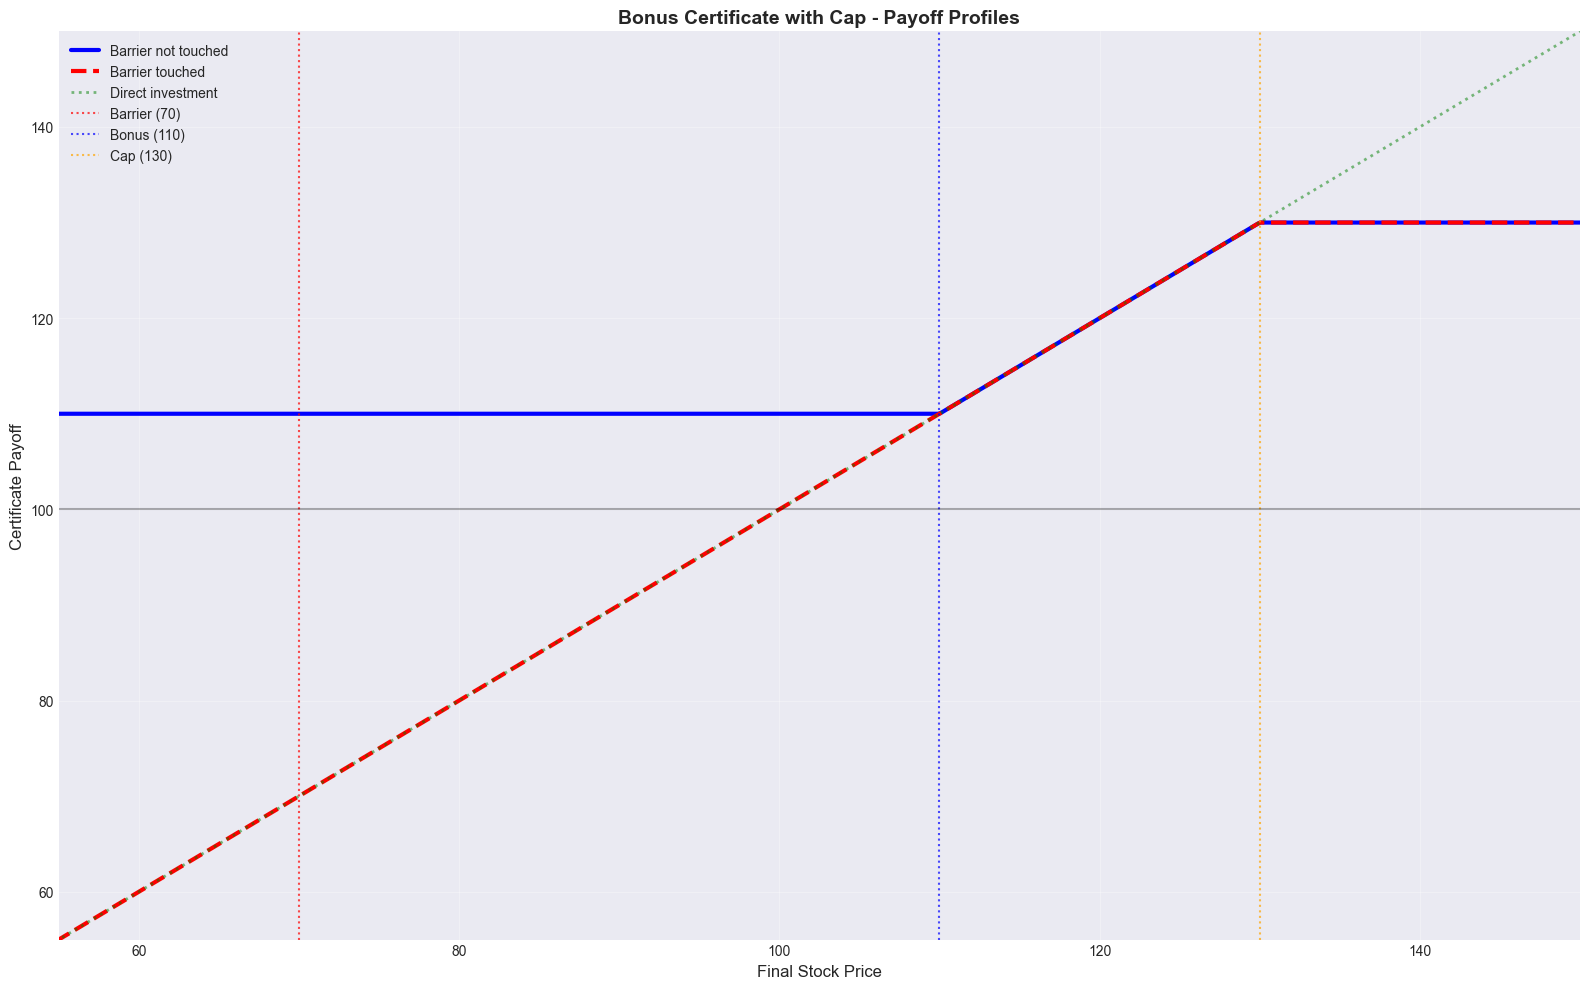

In [7]:
# Create visualization of payoff profile
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

# Parameters for visualization
P0 = 100
H = 70   # Barrier at 70%
B = 110  # Bonus at 110%
C = 130  # Cap at 130%

# Range of final prices
P_T = np.linspace(0, 150, 1000)

# Payoff if barrier not touched
payoff_no_touch = np.minimum(np.maximum(P_T, B), C)

# Payoff if barrier touched
payoff_touched = np.minimum(P_T, C)

# Plot 1: Payoff profiles
ax1.plot(P_T, payoff_no_touch, 'b-', linewidth=3, label='Barrier not touched')
ax1.plot(P_T, payoff_touched, 'r--', linewidth=3, label='Barrier touched')
ax1.plot(P_T, P_T, 'g:', linewidth=2, alpha=0.5, label='Direct investment')

# Add key levels
ax1.axvline(x=H, color='red', linestyle=':', alpha=0.7, label=f'Barrier ({H})')
ax1.axvline(x=B, color='blue', linestyle=':', alpha=0.7, label=f'Bonus ({B})')
ax1.axvline(x=C, color='orange', linestyle=':', alpha=0.7, label=f'Cap ({C})')
ax1.axhline(y=P0, color='black', linestyle='-', alpha=0.3)

ax1.set_xlabel('Final Stock Price', fontsize=12)
ax1.set_ylabel('Certificate Payoff', fontsize=12)
ax1.set_title('Bonus Certificate with Cap - Payoff Profiles', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(55, 150)
ax1.set_ylim(55, 150)

plt.tight_layout()
plt.show()

### 4. Replication Strategy

### Replication Portfolio for Bonus Certificate with Cap

A **Bonus Certificate with Cap** can be replicated using the following financial instruments:

---

#### 1. **Long Underlying Asset** (1 unit)

- Provides exposure to the full price movement of the underlying asset.

---

#### 2. **Long Down-and-Out Put (DOP)**

- **Strike**: $K = B$ (Bonus Level)  
- **Barrier**: $H$ (Barrier Level)  
- Acts as downside protection as long as the barrier is not breached.  
- If the barrier is touched, the put expires worthless—mirroring the loss of the bonus protection.

---

#### 3. **Short Call Option**

- **Strike**: $K = C$ (Cap Level)  
- Limits upside participation beyond the cap level.

---

### Mathematical Representation

The value of the replication portfolio at time $t$ is:

$$
V(t) = P(t) + \text{DOP}(P(t), B, H, T - t) - \text{Call}(P(t), C, T - t)
$$

Where:

- $V(t)$: Value of the replicating portfolio  
- $P(t)$: Price of the underlying asset at time $t$  
- $\text{DOP}$: Price of the Down-and-Out Put option with strike $B$ and barrier $H$  
- $\text{Call}$: Price of the European Call option with strike $C$

---

### Additional Insight

- The **Down-and-Out Put** ensures a minimum payout (the bonus) only if the barrier is never breached.  
- If the barrier is breached, the DOP becomes worthless, and the investor is exposed to the downside like a direct equity position (with a cap via the short call).  
- The **Short Call** limits any profit above the cap level.  
- This replication strategy mirrors the **path-dependent** nature of the Bonus Certificate while allowing it to be **priced using standard financial instruments**.


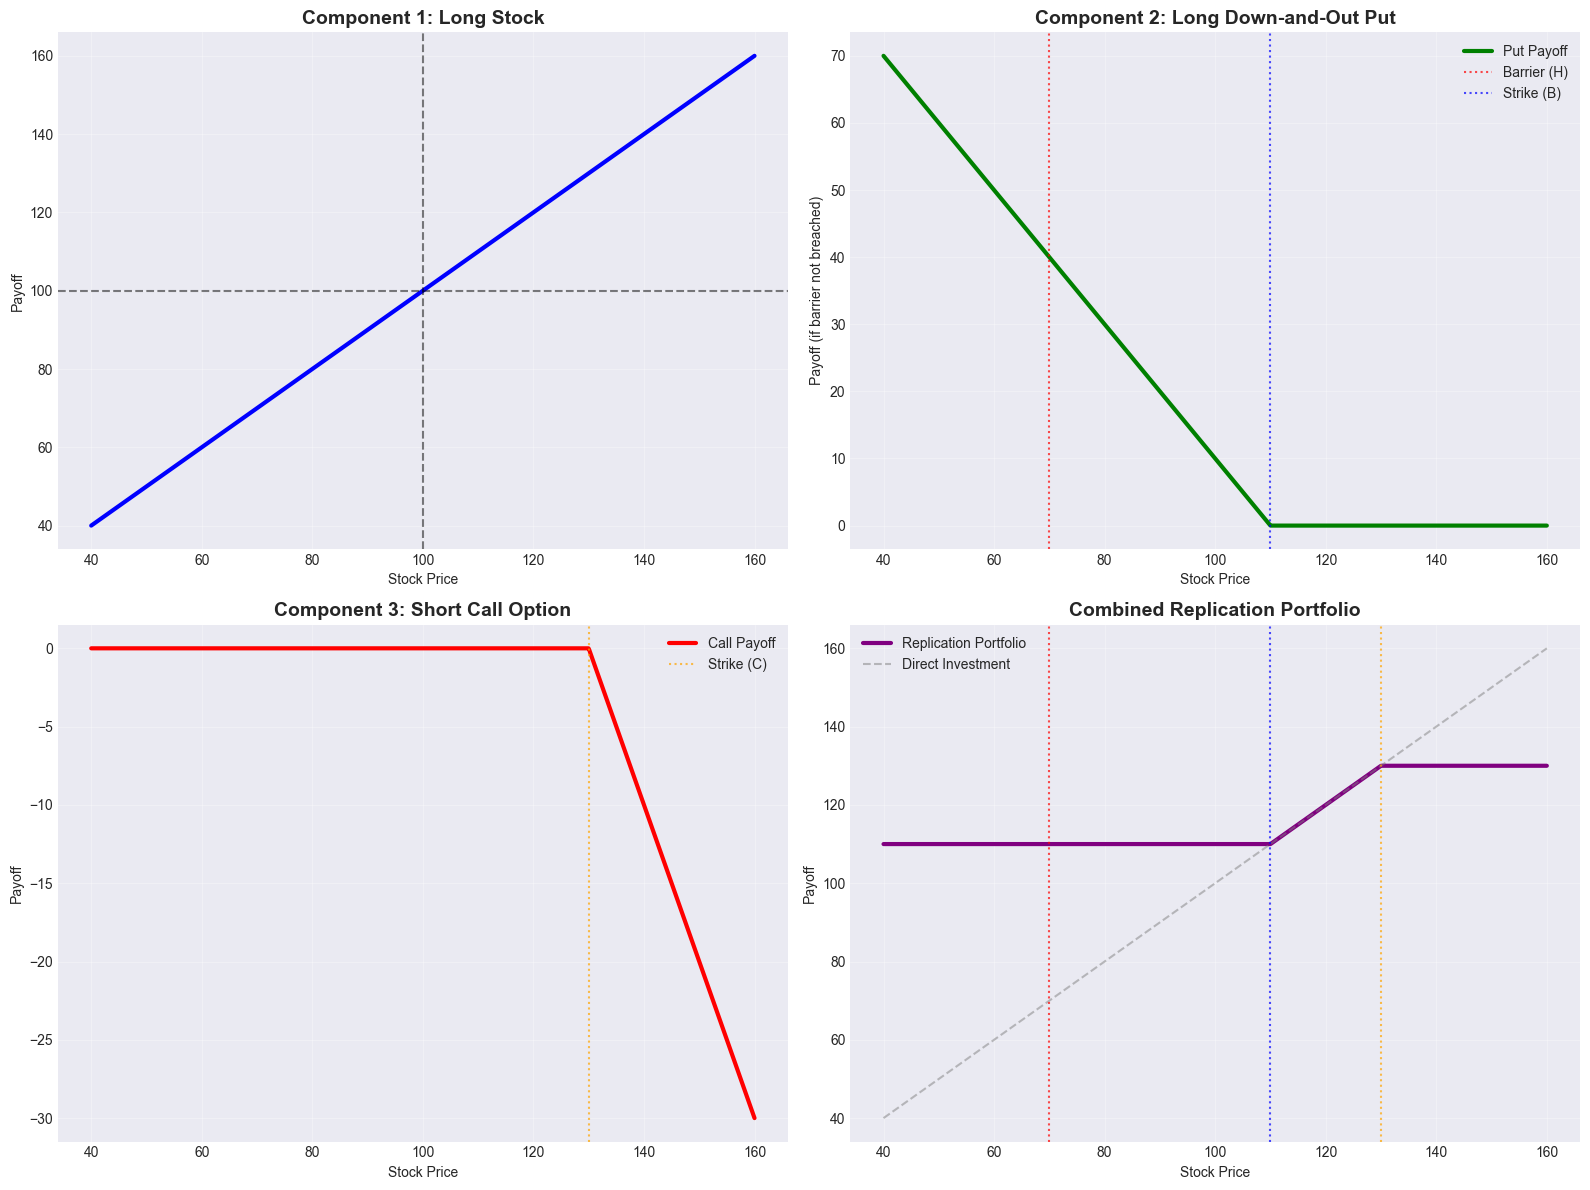

In [8]:
# Parameters
P0 = 100
H = 70
B = 110
C = 130
P_T = np.linspace(40, 160, 1000)

# Setup figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Component 1: Long Stock
ax = axes[0, 0]
ax.plot(P_T, P_T, 'b-', linewidth=3)
ax.axhline(y=P0, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=P0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Component 1: Long Stock', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff')
ax.grid(True, alpha=0.3)

# Component 2: Down-and-Out Put (approx. payoff if barrier not breached)
ax = axes[0, 1]
dop_payoff = np.where(P_T < B, B - P_T, 0)
ax.plot(P_T, dop_payoff, 'g-', linewidth=3, label='Put Payoff')
ax.axvline(x=H, color='red', linestyle=':', alpha=0.7, label='Barrier (H)')
ax.axvline(x=B, color='blue', linestyle=':', alpha=0.7, label='Strike (B)')
ax.set_title('Component 2: Long Down-and-Out Put', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff (if barrier not breached)')
ax.legend()
ax.grid(True, alpha=0.3)

# Component 3: Short Call
ax = axes[1, 0]
call_payoff = -np.maximum(P_T - C, 0)
ax.plot(P_T, call_payoff, 'r-', linewidth=3, label='Call Payoff')
ax.axvline(x=C, color='orange', linestyle=':', alpha=0.7, label='Strike (C)')
ax.set_title('Component 3: Short Call Option', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff')
ax.legend()
ax.grid(True, alpha=0.3)

# Component 4: Combined Replication Portfolio (simplified static payoff)
ax = axes[1, 1]
combined_payoff = np.minimum(np.maximum(P_T, B), C)
ax.plot(P_T, combined_payoff, 'purple', linewidth=3, label='Replication Portfolio')
ax.plot(P_T, P_T, 'gray', linestyle='--', alpha=0.5, label='Direct Investment')
ax.axvline(x=H, color='red', linestyle=':', alpha=0.7)
ax.axvline(x=B, color='blue', linestyle=':', alpha=0.7)
ax.axvline(x=C, color='orange', linestyle=':', alpha=0.7)
ax.set_title('Combined Replication Portfolio', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

### 5. Analytical Pricing

In [9]:
def black_scholes_call(P0, K, T, r, sigma):
    """Calculate Black-Scholes call option price."""
    def d1(P0, K, r, sigma, T):
        return (np.log(P0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    def d2(P, K, r, sigma, T):
        return d1(P0, K, r, sigma, T) - sigma * np.sqrt(T)

    d1_ = d1(P0, K, r, sigma, T)
    d2_ = d2(P0, K, r, sigma, T)
    
    call_price = P0 * norm.cdf(d1_) - K * np.exp(-r * T) * norm.cdf(d2_)
    
    return call_price

def down_and_out_call(P0, K, H, T, r, sigma):
    """Calculate Down-and-Out call option price using closed-form solution."""
    if P0 <= H:
        return 0.0
        
    def c1(P0, H, r, sigma, T):
        return (np.log(H**2/(P0*K)) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    def c2(P0, H, r, sigma, T):
        return c1(P0, H, r, sigma, T) - sigma * np.sqrt(T)
    
    doc_lambda = r - 0.5 * sigma**2
    kod = P0 * np.power(H/P0, 2 + 2 * doc_lambda / sigma**2) * norm.cdf(c1(P0, H, r, sigma, T)) - \
                K * np.exp(-r * T) * np.power(H/P0, 2 * doc_lambda / sigma**2) * norm.cdf(c2(P0, H, r, sigma, T))
    
    # Down-and-In Call pricing
    vanilla_call = black_scholes_call(P0, K, T, r, sigma)
    
    return vanilla_call - kod

def down_and_out_put(P0, K, H, T, r, sigma):
    """Calculate Down-and-Out put option price using closed-form solution."""
    if P0 <= H:
        return 0.0

    def q1(P0, H, r, sigma, T):
        term1 = norm.cdf((np.log(P0/H) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        term2_coef = np.exp(-2*(r + sigma**2/2)*np.log(P0/H)/sigma**2)
        term2_cdf = norm.cdf((-np.log(P0/H) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        return term1 - term2_coef * term2_cdf

    def q2(P0, H, r, sigma, T):
        term1 = norm.cdf((np.log(P0/H) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        term2_coef = np.exp(-2*(r - sigma**2/2)*np.log(P0/H)/sigma**2)
        term2_cdf = norm.cdf((-np.log(P0/H) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        return term1 - term2_coef * term2_cdf

    Q1 = q1(P0, H, r, sigma, T)
    Q2 = q2(P0, H, r, sigma, T)
    
    doc = down_and_out_call(P0, K, H, T, r, sigma)

    return doc - P0 * Q1 + K * np.exp(-r * T) * Q2

def price_bonus_certificate_analytical(P0, H, B, C, T, r, sigma):
    """
    Price a Bonus Certificate with Cap using analytical formula.
    """
    # Component 1: Long stock
    stock_value = P0
    
    # Component 2: Down-and-Out Put with strike at Bonus level
    dop_value = down_and_out_put(P0, B, H, T, r, sigma)
    
    # Component 3: Short Call at Cap level
    call_value = black_scholes_call(P0, C, T, r, sigma)
    
    # Total certificate value
    certificate_value = stock_value + dop_value - call_value
    
    results = {
        'price': certificate_value,
        'components': {
            'stock': stock_value,
            'down_out_put': dop_value,
            'short_call': -call_value
        }
    }
    
    return results

In [10]:
# Market parameters
P0 = df['Close'].iloc[-1]  # Last closing price
r = 0.02  # Risk-free rate
sigma = bs_params['volatility']
T = 1.0  # 1 year maturity

# Certificate parameters
H = 16  # Barrier
B = 24  # Bonus
C = 28  # Cap

print(f"Market Parameters:")
print(f"Current Price (P0): {P0:.2f}")
print(f"Risk-free Rate: {r:.2%}")
print(f"Volatility: {sigma:.2%}")
print(f"Time to Maturity: {T} year")

print(f"\nCertificate Parameters:")
print(f"Barrier Level: {H}")
print(f"Bonus Level: {B}")
print(f"Cap Level: {C}")

analytical_price = price_bonus_certificate_analytical(P0, H, B, C, T, r, sigma)

print(f"\nAnalytical Pricing Results:")
print(f"Certificate Price: {analytical_price['price']:.4f}")
print(f"\nComponents:")
for component, value in analytical_price['components'].items():
    print(f"  {component}: {value:.4f}")

Market Parameters:
Current Price (P0): 22.63
Risk-free Rate: 2.00%
Volatility: 21.24%
Time to Maturity: 1.0 year

Certificate Parameters:
Barrier Level: 16
Bonus Level: 24
Cap Level: 28

Analytical Pricing Results:
Certificate Price: 23.7293

Components:
  stock: 22.6300
  down_out_put: 1.6210
  short_call: -0.5217


### 6. Monte Carlo Simulation

In [11]:
@jit(nopython=True, parallel=True)
def simulate_paths_with_tracking(P0, H, B, C, T, r, sigma, n_simulations, n_steps):
    """
    Simulation that tracks barrier breaches and final prices.
    """
    dt = T / n_steps
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    payoffs = np.zeros(n_simulations)
    barrier_breached = np.zeros(n_simulations, dtype=np.bool_)
    final_prices = np.zeros(n_simulations)
    
    # Process in parallel
    for i in prange(n_simulations):
        P = P0
        barrier_hit = False
        
        # Simulate path with early termination
        for step in range(n_steps):
            z = np.random.standard_normal()
            P = P * np.exp(drift + diffusion * z)
            
            # Check barrier breach
            if P <= H and not barrier_hit:
                barrier_hit = True
                # Continue to get final price but mark as breached
        
        # Store results
        barrier_breached[i] = barrier_hit
        final_prices[i] = P
        
        # Calculate payoff
        if barrier_hit:
            payoffs[i] = min(P, C)
        else:
            payoffs[i] = min(max(P, B), C)
    
    return payoffs, barrier_breached, final_prices

def monte_carlo_bonus_certificate(P0, H, B, C, T, r, sigma, n_simulations=100000, n_steps=252):
    """
    Price Bonus Certificate with Cap using Monte Carlo simulation.
    
    Parameters:
    -----------
    P0 : float
        Initial stock price
    H : float
        Barrier level
    B : float
        Bonus level
    C : float
        Cap level
    T : float
        Time to maturity
    r : float
        Risk-free rate
    sigma : float
        Volatility
    n_simulations : int
        Number of Monte Carlo paths
    n_steps : int
        Number of time steps per path
        
    Returns:
    --------
    dict : Dictionary containing price estimate and confidence interval
    """
    payoffs, barrier_breached, final_prices = simulate_paths_with_tracking(
        P0, H, B, C, T, r, sigma, n_simulations, n_steps
    )
    
    # Discount to present value
    discounted_payoffs = payoffs * np.exp(-r * T)
    
    # Calculate price and confidence interval
    price = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(n_simulations)
    conf_interval = (price - 1.96 * std_error, price + 1.96 * std_error)
    
    # Calculate additional statistics (same as original)
    prob_barrier_breach = np.mean(barrier_breached)
    
    # Separate payoffs by breach status
    no_breach_mask = ~barrier_breached
    breach_mask = barrier_breached
    
    avg_payoff_no_breach = np.mean(payoffs[no_breach_mask]) if np.any(no_breach_mask) else 0
    avg_payoff_breach = np.mean(payoffs[breach_mask]) if np.any(breach_mask) else 0
    
    results = {
        'price': price,
        'std_error': std_error,
        'confidence_interval_95': conf_interval,
        'statistics': {
            'prob_barrier_breach': prob_barrier_breach,
            'avg_payoff_no_breach': avg_payoff_no_breach,
            'avg_payoff_breach': avg_payoff_breach,
            'paths_simulated': n_simulations
        }
    }
    
    return results

def monte_carlo_bonus_certificate_with_plots(P0, H, B, C, T, r, sigma, n_simulations=100000, n_steps=252, 
                                           show_plots=True, n_plot_paths=100):
    """
    
    Parameters:
    -----------
    show_plots : bool
        Whether to generate visualization plots
    n_plot_paths : int
        Number of paths to simulate for plotting (separate from main simulation)
    """
    
    # Get main results using fast method
    results = monte_carlo_bonus_certificate(P0, H, B, C, T, r, sigma, n_simulations, n_steps)
    
    if show_plots:
        print(f"Generating plots with {n_plot_paths} sample paths...")
        
        # Generate smaller set of paths for visualization only
        dt = T / n_steps
        Z_plot = np.random.standard_normal((n_plot_paths, n_steps))
        
        # Generate paths for plotting
        paths = np.zeros((n_plot_paths, n_steps + 1))
        paths[:, 0] = P0
        barrier_breached_plot = np.zeros(n_plot_paths, dtype=bool)
        
        for t in range(1, n_steps + 1):
            paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + 
                                                  sigma * np.sqrt(dt) * Z_plot[:, t-1])
            barrier_breached_plot |= (paths[:, t] <= H)
        
        # Calculate payoffs for plotting
        S_T_plot = paths[:, -1]
        payoffs_plot = np.zeros(n_plot_paths)
        
        no_breach_mask = ~barrier_breached_plot
        breach_mask = barrier_breached_plot
        
        payoffs_plot[no_breach_mask] = np.minimum(np.maximum(S_T_plot[no_breach_mask], B), C)
        payoffs_plot[breach_mask] = np.minimum(S_T_plot[breach_mask], C)
        
        discounted_payoffs_plot = payoffs_plot * np.exp(-r * T)
        
        # Create plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Sample paths
        time_grid = np.linspace(0, T, n_steps + 1)
        
        for i in range(min(n_plot_paths, 100)):
            color = 'red' if barrier_breached_plot[i] else 'blue'
            alpha = 0.1 if barrier_breached_plot[i] else 0.2
            ax1.plot(time_grid, paths[i, :], color=color, alpha=alpha, linewidth=0.5)
        
        ax1.axhline(y=H, color='red', linestyle='--', linewidth=2, label=f'Barrier ({H})')
        ax1.axhline(y=B, color='green', linestyle='--', linewidth=2, label=f'Bonus ({B})')
        ax1.axhline(y=C, color='orange', linestyle='--', linewidth=2, label=f'Cap ({C})')
        ax1.set_xlabel('Time (years)', fontsize=12)
        ax1.set_ylabel('Stock Price', fontsize=12)
        ax1.set_title(f'Monte Carlo Simulation Paths (showing {min(n_plot_paths, 100)} paths)', 
                      fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Payoff distribution (use actual results, not plot data)
        # Generate more payoffs for better histogram
        payoffs_hist, _, _ = simulate_paths_with_tracking(P0, H, B, C, T, r, sigma, 
                                                         min(10000, n_simulations), n_steps)
        discounted_hist = payoffs_hist * np.exp(-r * T)
        
        ax2.hist(discounted_hist, bins=50, density=True, alpha=0.7, 
                 color='skyblue', edgecolor='black')
        ax2.axvline(x=results['price'], color='red', linestyle='--', linewidth=2, 
                    label=f"Mean: {results['price']:.2f}")
        ci = results['confidence_interval_95']
        ax2.axvline(x=ci[0], color='orange', linestyle=':', linewidth=2,
                    label=f'95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]')
        ax2.axvline(x=ci[1], color='orange', linestyle=':', linewidth=2)
        ax2.set_xlabel('Discounted Payoff', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Distribution of Discounted Payoffs', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating plots with 100 sample paths...


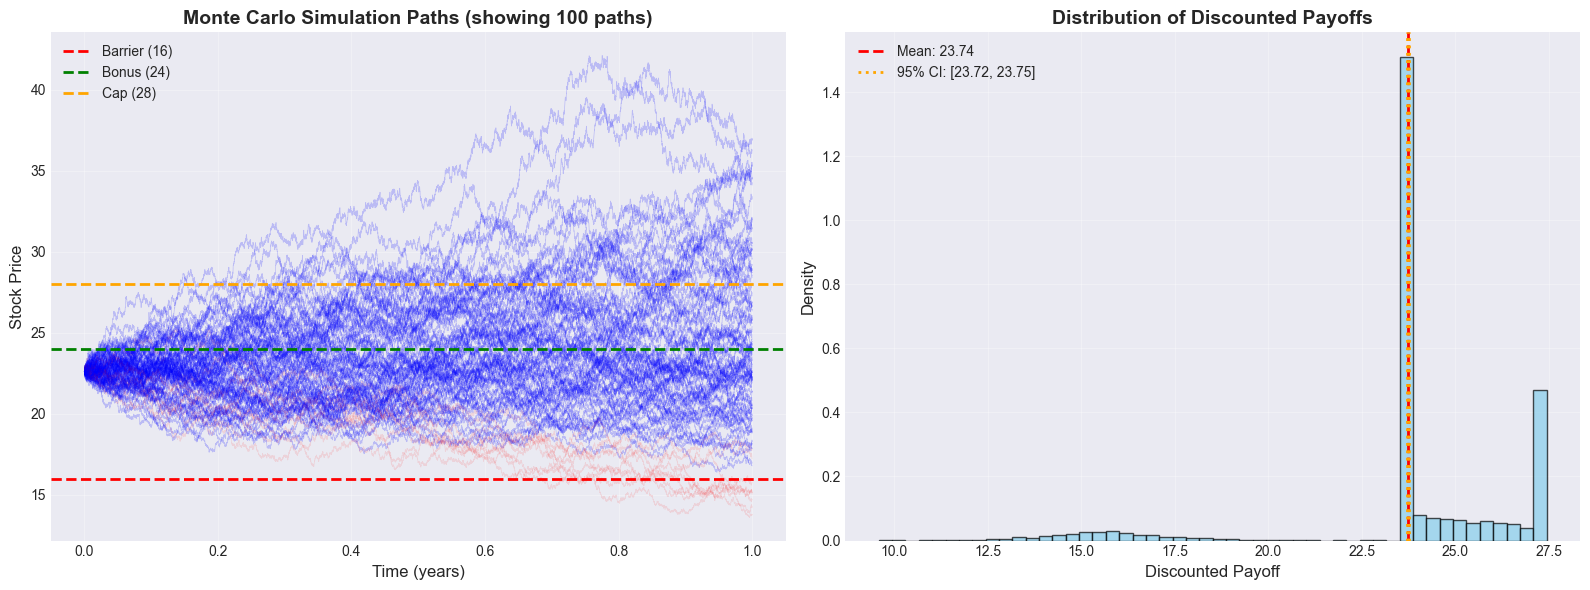


Monte Carlo Results:
Price Estimate: 23.7352
Standard Error: 0.010014
95% Confidence Interval: [23.7155, 23.7548]

Simulation Statistics:
  prob_barrier_breach: 10.38%
  avg_payoff_no_breach: 25.16
  avg_payoff_breach: 16.06
  paths_simulated: 100000.00

Pricing Difference (MC vs Analytical): 0.0059


In [12]:
mc_results = monte_carlo_bonus_certificate_with_plots(P0, H, B, C, T, r, sigma, n_simulations=100000, n_steps=10000, show_plots=True)

print(f"\nMonte Carlo Results:")
print(f"Price Estimate: {mc_results['price']:.4f}")
print(f"Standard Error: {mc_results['std_error']:.6f}")
print(f"95% Confidence Interval: [{mc_results['confidence_interval_95'][0]:.4f}, "
        f"{mc_results['confidence_interval_95'][1]:.4f}]")
print(f"\nSimulation Statistics:")
for stat, value in mc_results['statistics'].items():
    if 'prob' in stat:
        print(f"  {stat}: {value:.2%}")
    else:
        print(f"  {stat}: {value:.2f}")

print(f"\nPricing Difference (MC vs Analytical): "
        f"{abs(mc_results['price'] - analytical_price['price']):.4f}")

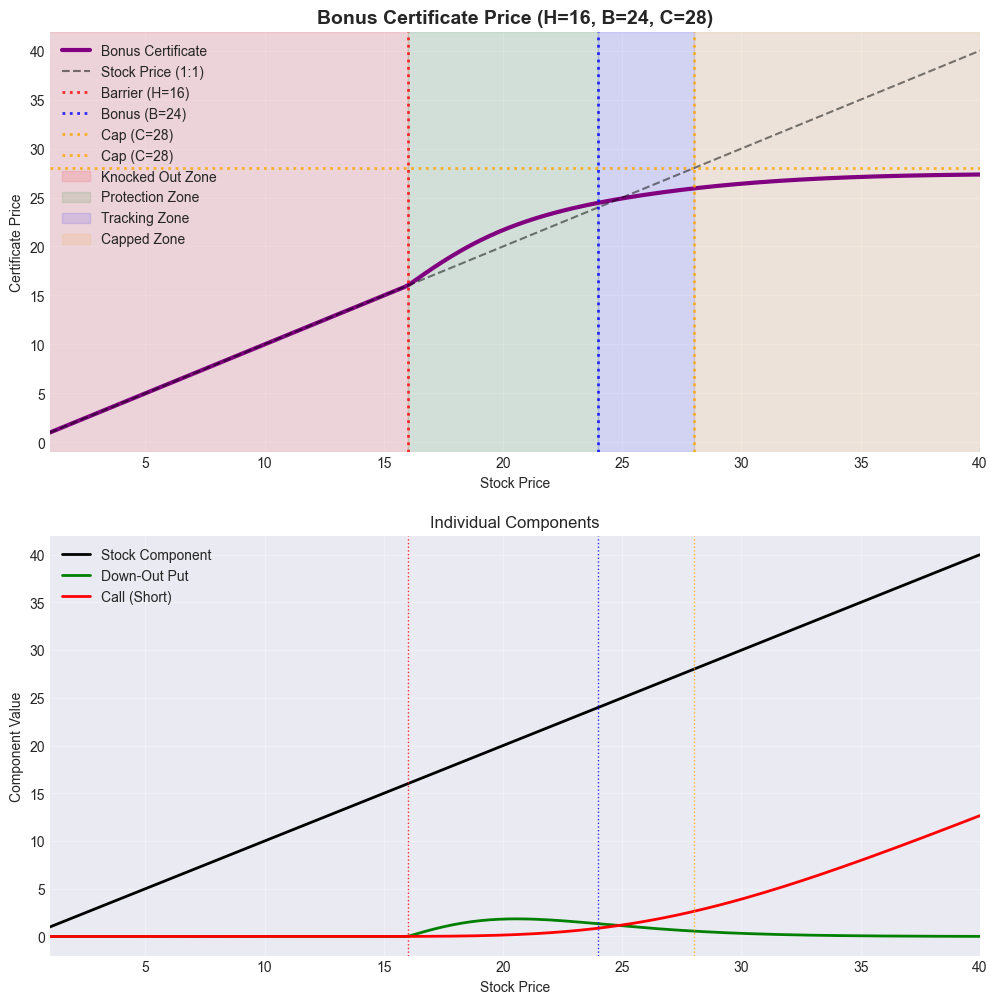

In [24]:
stock_prices = np.linspace(1, 40, 200)

# Calculate certificate components
cert_prices = []
stock_values = []
dop_values = []
call_values = []

for S in stock_prices:
    try:
        result = price_bonus_certificate_analytical(S, H, B, C, T, r, sigma)
        cert_prices.append(result['price'])
        stock_values.append(result['components']['stock'])
        dop_values.append(result['components']['down_out_put'])
        call_values.append(-result['components']['short_call'])  # Negative because it's short
    except:
        # Handle any numerical issues
        cert_prices.append(np.nan)
        stock_values.append(S)
        dop_values.append(0)
        call_values.append(0)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Total Certificate Price
ax1.plot(stock_prices, cert_prices, 'purple', linewidth=3, label='Bonus Certificate')
ax1.plot(stock_prices, stock_prices, 'k--', alpha=0.5, label='Stock Price (1:1)')

# Mark key levels
ax1.axvline(x=H, color='red', linestyle=':', alpha=0.8, linewidth=2, label=f'Barrier (H={H})')
ax1.axvline(x=B, color='blue', linestyle=':', alpha=0.8, linewidth=2, label=f'Bonus (B={B})')
ax1.axvline(x=C, color='orange', linestyle=':', alpha=0.8, linewidth=2, label=f'Cap (C={C})')
ax1.axhline(y=C, color='orange', linestyle=':', alpha=0.8, linewidth=2, label=f'Cap (C={C})')

# Add zones
ax1.axvspan(0, H, alpha=0.1, color='red', label='Knocked Out Zone')
ax1.axvspan(H, B, alpha=0.1, color='green', label='Protection Zone')
ax1.axvspan(B, C, alpha=0.1, color='blue', label='Tracking Zone')
ax1.axvspan(C, 40, alpha=0.1, color='orange', label='Capped Zone')

ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Certificate Price')
ax1.set_title('Bonus Certificate Price (H=16, B=24, C=28)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 40)

# Plot 2: Individual Components
ax2.plot(stock_prices, stock_values, 'black', linewidth=2, label='Stock Component')
ax2.plot(stock_prices, dop_values, 'green', linewidth=2, label='Down-Out Put')
ax2.plot(stock_prices, call_values, 'red', linewidth=2, label='Call (Short)')

# Mark key levels
ax2.axvline(x=H, color='red', linestyle=':', alpha=0.8, linewidth=1)
ax2.axvline(x=B, color='blue', linestyle=':', alpha=0.8, linewidth=1)
ax2.axvline(x=C, color='orange', linestyle=':', alpha=0.8, linewidth=1)

ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Component Value')
ax2.set_title('Individual Components', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 40);

### 7. Risk Analysis

In [15]:
def simulate_physical_measure(P0, mu, sigma, T, n_simulations=10000, n_steps=252):
    """
    Simulate stock and certificate payoffs under physical (real-world) measure.
    
    Parameters:
    -----------
    P0 : float
        Initial stock price
    mu : float
        Real-world drift (from Task 2)
    sigma : float
        Volatility
    T : float
        Time to maturity
    n_simulations : int
        Number of simulations
    n_steps : int
        Number of time steps
        
    Returns:
    --------
    dict : Simulation results and risk metrics
    """
    # Certificate parameters
    H = 16  # Barrier
    B = 24  # Bonus
    C = 28  # Cap
    
    dt = T / n_steps
    
    # Generate paths under physical measure
    Z = np.random.standard_normal((n_simulations, n_steps))
    paths = np.zeros((n_simulations, n_steps + 1))
    paths[:, 0] = P0
    
    barrier_breached = np.zeros(n_simulations, dtype=bool)
    
    for t in range(1, n_steps + 1):
        paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + 
                                              sigma * np.sqrt(dt) * Z[:, t-1])
        barrier_breached |= (paths[:, t] <= H)
    
    # Final prices
    P_T = paths[:, -1]
    
    # Certificate payoffs
    cert_payoffs = np.zeros(n_simulations)
    no_breach = ~barrier_breached
    cert_payoffs[no_breach] = np.minimum(np.maximum(P_T[no_breach], B), C)
    cert_payoffs[barrier_breached] = np.minimum(P_T[barrier_breached], C)
    
    # Stock returns
    stock_returns = P_T / P0
    cert_returns = cert_payoffs / P0
    
    # Calculate risk metrics
    def calculate_risk_metrics(returns):
        """Calculate comprehensive risk metrics."""
        log_returns = np.log(returns)
        
        metrics = {
            'mean': np.mean(returns),
            'std': np.std(returns),
            'log_mean': np.mean(log_returns),
            'log_std': np.std(log_returns),
            'skewness': stats.skew(log_returns),
            'kurtosis': stats.kurtosis(log_returns),
            'var_5': np.percentile(returns, 5),  # 5% VaR
            'cvar_5': np.mean(returns[returns <= np.percentile(returns, 5)]),  # 5% CVaR
            'max_return': np.max(returns),
            'min_return': np.min(returns),
            'sharpe_ratio': (np.mean(returns) - 1) / np.std(returns) if np.std(returns) > 0 else 0,
            'prob_loss': np.mean(returns < 1),
            'prob_gain_10pct': np.mean(returns > 1.1),
            'prob_max_return': np.mean(returns >= C/P0)  # For certificate
        }
        
        return metrics
    
    stock_metrics = calculate_risk_metrics(stock_returns)
    cert_metrics = calculate_risk_metrics(cert_returns)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Return distributions
    ax = axes[0, 0]
    bins = np.linspace(min(stock_returns.min(), cert_returns.min()), 
                      max(stock_returns.max(), cert_returns.max()), 50)
    ax.hist(stock_returns, bins=bins, alpha=0.5, label='Stock', density=True, color='blue')
    ax.hist(cert_returns, bins=bins, alpha=0.5, label='Certificate', density=True, color='red')
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Return Multiple', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Return Distributions (Physical Measure)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Q-Q plot
    ax = axes[0, 1]
    stats.probplot(cert_returns - stock_returns, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot: Certificate vs Stock Returns', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Risk-Return scatter
    ax = axes[1, 0]
    # Create percentile buckets
    percentiles = np.linspace(5, 95, 19)
    stock_percentiles = [np.percentile(stock_returns, p) for p in percentiles]
    cert_percentiles = [np.percentile(cert_returns, p) for p in percentiles]
    
    ax.scatter(stock_percentiles, cert_percentiles, s=50, alpha=0.7)
    ax.plot([0.5, 1.5], [0.5, 1.5], 'k--', alpha=0.5, label='45° line')
    
    # Highlight specific percentiles
    for p, sp, cp in zip(percentiles, stock_percentiles, cert_percentiles):
        if p in [5, 25, 50, 75, 95]:
            ax.annotate(f'{p}%', (sp, cp), xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Stock Return', fontsize=12)
    ax.set_ylabel('Certificate Return', fontsize=12)
    ax.set_title('Return Percentiles Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Plot 4: Risk metrics comparison
    ax = axes[1, 1]
    metrics_names = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'VaR 5%', 'CVaR 5%']
    stock_values = [stock_metrics['mean'], stock_metrics['std'], 
                   stock_metrics['skewness'], stock_metrics['kurtosis'],
                   stock_metrics['var_5'], stock_metrics['cvar_5']]
    cert_values = [cert_metrics['mean'], cert_metrics['std'],
                  cert_metrics['skewness'], cert_metrics['kurtosis'],
                  cert_metrics['var_5'], cert_metrics['cvar_5']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    ax.bar(x - width/2, stock_values, width, label='Stock', alpha=0.7)
    ax.bar(x + width/2, cert_values, width, label='Certificate', alpha=0.7)
    
    ax.set_xlabel('Risk Metric', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title('Risk Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*60)
    print("RISK METRICS COMPARISON (Physical Measure)")
    print("="*60)
    print(f"{'Metric':<25} {'Stock':>12} {'Certificate':>12} {'Difference':>12}")
    print("-"*60)
    
    for metric in ['mean', 'std', 'skewness', 'kurtosis', 'var_5', 'cvar_5', 
                   'sharpe_ratio', 'prob_loss', 'prob_gain_10pct']:
        stock_val = stock_metrics[metric]
        cert_val = cert_metrics[metric]
        diff = cert_val - stock_val
        print(f"{metric:<25} {stock_val:>12.4f} {cert_val:>12.4f} {diff:>12.4f}")
    
    print("\nBarrier Breach Probability:", f"{np.mean(barrier_breached):.2%}")
    print("Certificate at Max Payout:", f"{cert_metrics['prob_max_return']:.2%}")
    
    return {
        'stock_returns': stock_returns,
        'cert_returns': cert_returns,
        'stock_metrics': stock_metrics,
        'cert_metrics': cert_metrics,
        'barrier_breach_prob': np.mean(barrier_breached),
        'paths': paths  # For further analysis if needed
    }

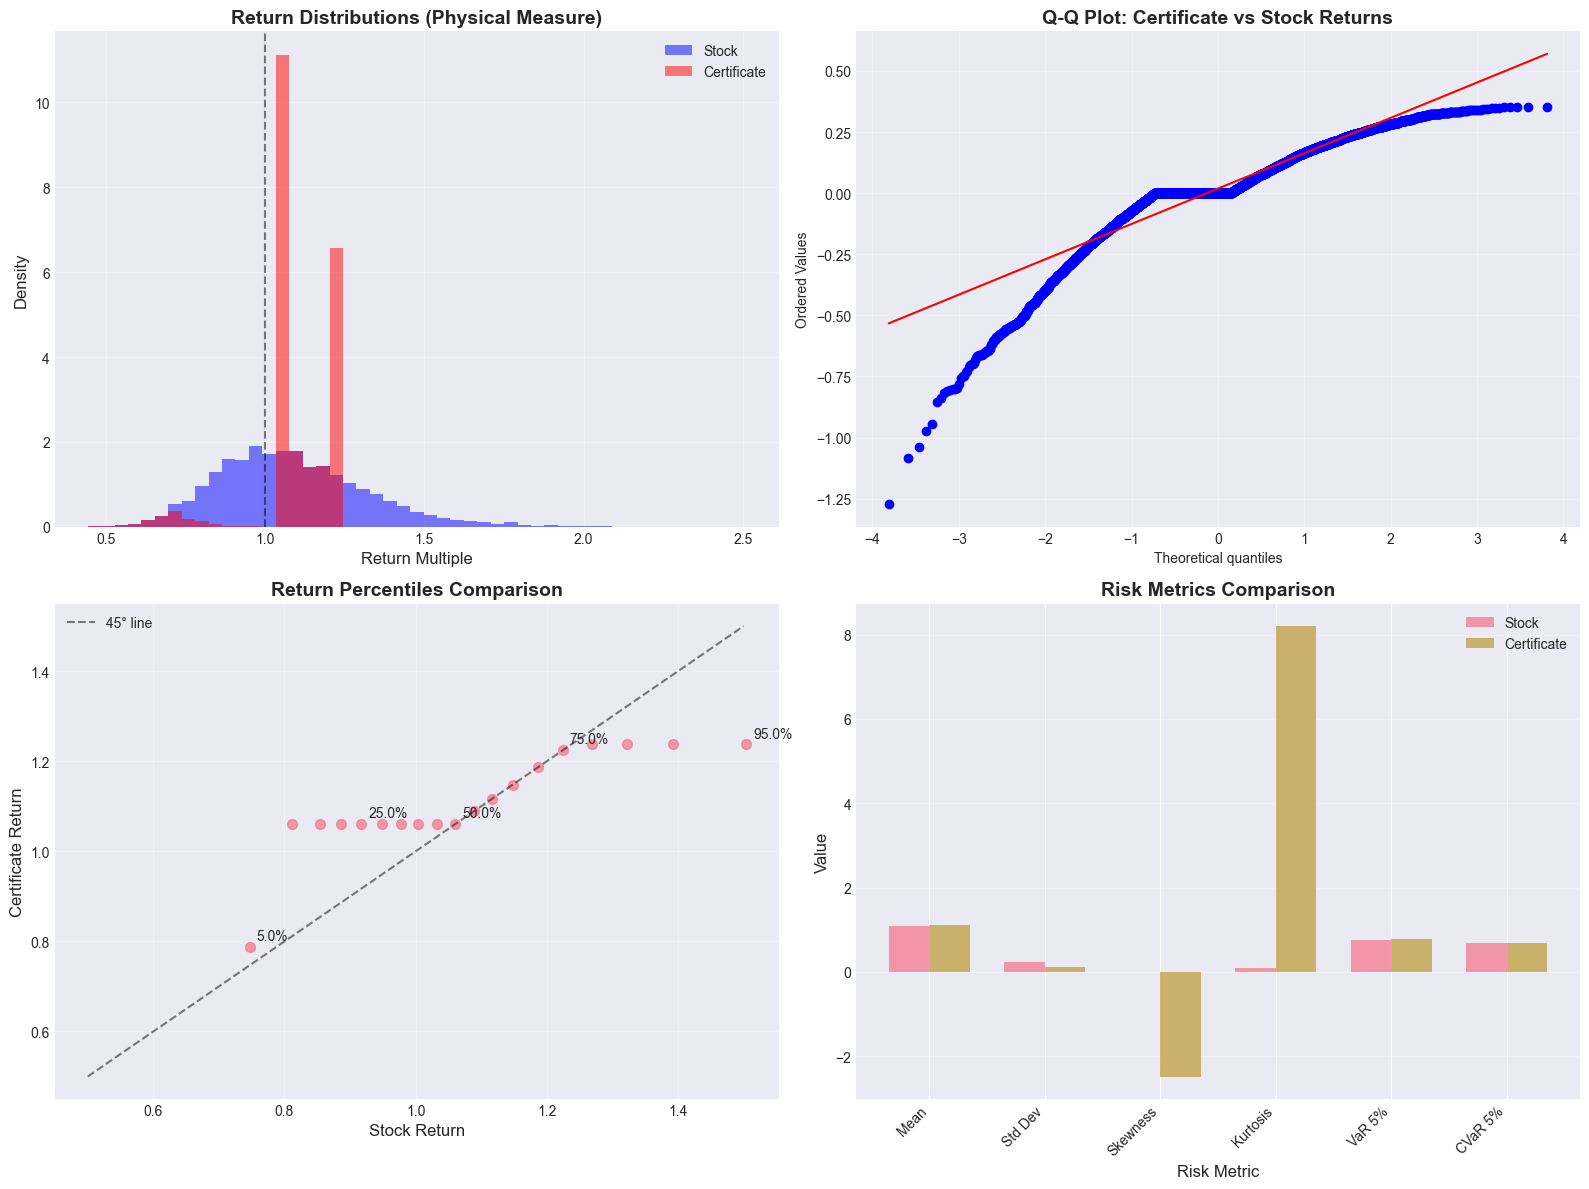


RISK METRICS COMPARISON (Physical Measure)
Metric                           Stock  Certificate   Difference
------------------------------------------------------------
mean                            1.0846       1.1032       0.0186
std                             0.2342       0.1242      -0.1100
skewness                       -0.0009      -2.4801      -2.4793
kurtosis                        0.0909       8.2007       8.1099
var_5                           0.7467       0.7886       0.0419
cvar_5                          0.6825       0.6892       0.0066
sharpe_ratio                    0.3612       0.8309       0.4696
prob_loss                       0.3954       0.0584      -0.3370
prob_gain_10pct                 0.4294       0.4294       0.0000

Barrier Breach Probability: 5.86%
Certificate at Max Payout: 23.44%

Key Observations:
1. The certificate reduces volatility by 47.0%
2. Downside protection active in 94.1% of scenarios
3. Maximum return capped in 23.4% of scenarios
4. Certific

In [16]:
physical_results = simulate_physical_measure(P0, bs_params['drift'], sigma, T)

print("\nKey Observations:")
print(f"1. The certificate reduces volatility by {(1 - physical_results['cert_metrics']['std']/physical_results['stock_metrics']['std']):.1%}")
print(f"2. Downside protection active in {(1 - physical_results['barrier_breach_prob']):.1%} of scenarios")
print(f"3. Maximum return capped in {physical_results['cert_metrics']['prob_max_return']:.1%} of scenarios")
print(f"4. Certificate outperforms in {np.mean(physical_results['cert_returns'] > physical_results['stock_returns']):.1%} of scenarios")